In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.layers import Conv1D, Dense, Dropout, LayerNormalization, Bidirectional, LSTM, GRU, Layer, SpatialDropout1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Lambda, Reshape, Flatten, Input, MultiHeadAttention, Flatten, Concatenate, Add, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

2025-11-27 12:41:11.964436: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def clean_and_interpolate(data):
    df = pd.DataFrame(data).astype(np.float32)
    
    df_linear = df.interpolate(method='linear', limit_direction='both', axis=1, limit=None)
    df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)

    df_final = df_spline.fillna(0)
    
    # Clip extreme values
    df_interpolated_fin = df_final.clip(-1e6, 1e6)
    print(f"Final NaN count: {df_interpolated_fin.isnull().sum().sum()}")
    result = df_interpolated_fin.values
    
    return result

In [3]:
# Slope + elevation - fixed constraint

def multi_focal_loss_slope_elevation_constraint(slope_values, elevation_values,
                                                slope_threshold=40, elevation_threshold=2000,
                                                alpha=0.25, gamma=2.0,
                                                lambda_slope=0.4, lambda_elevation=0.3):
    def loss(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred_clipped = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        ce = -y_true * tf.math.log(y_pred_clipped)
        p_t = tf.where(tf.equal(y_true, 1), y_pred_clipped, 1 - y_pred_clipped)
        
        # Alpha weighting for class imbalance
        alpha_t = tf.where(tf.equal(y_true[:, 1], 1), alpha, 1 - alpha)
        
        # Focal loss calculation
        focal_weight = tf.expand_dims(alpha_t, 1) * tf.pow((1 - p_t), gamma)
        focal_loss = focal_weight * ce
        focal_loss = tf.reduce_mean(tf.reduce_sum(focal_loss, axis=1))
        
        # Get batch data
        batch_size = tf.shape(y_pred)[0]
        slope_batch = tf.gather(slope_values, tf.range(batch_size))
        elevation_batch = tf.gather(elevation_values, tf.range(batch_size))
        
        # ISA predictions
        isa_pred = y_pred[:, 0]
        
        # CONSTRAINT 1: Slope constraint
        slope_mask = tf.cast(slope_batch > slope_threshold, tf.float32)
        slope_penalty = tf.reduce_mean(tf.multiply(slope_mask, isa_pred))
        
        # CONSTRAINT 2: Elevation constraint
        elevation_mask = tf.cast(elevation_batch > elevation_threshold, tf.float32)
        elevation_penalty = tf.reduce_mean(tf.multiply(elevation_mask, isa_pred))
        
        # Combine all losses
        total_loss = focal_loss + (lambda_slope * slope_penalty) + (lambda_elevation * elevation_penalty)
        
        return total_loss
    
    return loss

In [4]:
def prepare_multi_region_data(ph_paths, kor_paths, cbr_paths):
    def load_region_data(paths):
        # Load all dataframes for a region
        ndvi_df = pd.read_csv(paths['ndvi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        mndwi_df = pd.read_csv(paths['mndwi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        ndbi_df = pd.read_csv(paths['ndbi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        ndbsi_df = pd.read_csv(paths['ndbsi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        cbi_df = pd.read_csv(paths['cbi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        uci_df = pd.read_csv(paths['uci'],delimiter=';', encoding='utf-8-sig',decimal=',')
        print('NDVI shape before int:', ndvi_df.shape)
        
        # Extract features
        ndvi_features = ndvi_df.iloc[:,5:29].values
        mndwi_features = mndwi_df.iloc[:,5:29].values
        ndbi_features = ndbi_df.iloc[:,5:29].values
        ndbsi_features = ndbsi_df.iloc[:,5:29].values
        cbi_features = cbi_df.iloc[:,5:29].values
        uci_features = uci_df.iloc[:,5:29].values
        print('NDVI shape after int:', ndvi_features.shape)
        
        # Clean and interpolate
        ndvi_features = clean_and_interpolate(ndvi_features)
        mndwi_features = clean_and_interpolate(mndwi_features)
        ndbi_features = clean_and_interpolate(ndbi_features)
        ndbsi_features = clean_and_interpolate(ndbsi_features)
        cbi_features = clean_and_interpolate(cbi_features)
        uci_features = clean_and_interpolate(uci_features)
        
        # Combine features
        X = np.concatenate([ndvi_features, mndwi_features, ndbi_features, 
                            ndbsi_features, cbi_features, uci_features], axis=1)

        print("X afer concatenate", X.shape)
        
        # Reshape
        X = X.reshape(X.shape[0], 24, 6)
        print("X afer reshape", X.shape)
        
        # Get labels, slope and aspect
        labels = ndvi_df.iloc[:, 1].values
        slope_values = ndvi_df.iloc[:,29].values
        aspect_values = ndvi_df.iloc[:,30].values
        
        # return X, labels, slope_values
        return X, labels, slope_values, aspect_values

    # Load data for both regions
    X_ph, labels_ph, slope_ph, elev_ph = load_region_data(ph_paths)
    X_kor, labels_kor, slope_kor, elev_kor = load_region_data(kor_paths)
    X_cbr, labels_cbr, slope_cbr, elev_cbr = load_region_data(cbr_paths)
    
    # Combine data from both regions
    X_combined = np.concatenate([X_ph, X_kor, X_cbr], axis=0)
    labels_combined = np.concatenate([labels_ph, labels_kor, labels_cbr])
    slope_combined = np.concatenate([slope_ph, slope_kor, slope_cbr])
    elev_combined = np.concatenate([elev_ph, elev_kor, elev_cbr])
    
    # Compute class weights on combined data
    unique_classes = np.unique(labels_combined)

    print("Labels combined shape:", labels_combined.shape)
    print("Labels combined type:", type(labels_combined[0]) if len(labels_combined) > 0 else "Empty")
    print("Unique classes from np.unique:", unique_classes)
    print("Unique classes type:", type(unique_classes[0]) if len(unique_classes) > 0 else "Empty")
    print("All unique values in labels_combined:", set(labels_combined))
    print("Any NaN values?", np.any(pd.isna(labels_combined)))

    # Check if there are any labels in y that aren't in classes
    missing_labels = set(labels_combined) - set(unique_classes)
    print("Labels in y but not in classes:", missing_labels)
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=labels_combined)
    
    class_weight_dict = dict(enumerate(class_weights))
    print("Class weights:", class_weight_dict)
    
    y = np.asarray(labels_combined)
    print(y)
    print(len(np.unique(y)))
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_combined = label_encoder.fit_transform(labels_combined)
    y_combined = to_categorical(y_combined)
    print(y_combined)
    
    # Split combined data
    X_train, X_test, y_train, y_test, slope_train, slope_test, elev_train, elev_test = train_test_split(X_combined, y_combined,
                                                                                                            slope_combined, elev_combined,
                                                                                                            test_size=0.3,random_state=42,
                                                                                                            stratify=y_combined)
    
    # Convert slope values to tensorflow constant
    slope_train = tf.constant(slope_train, dtype=tf.float32)
    slope_test = tf.constant(slope_test, dtype=tf.float32)

    # Convert aspect values to tensorflow constant
    elev_train = tf.constant(elev_train, dtype=tf.float32)
    elev_test = tf.constant(elev_test, dtype=tf.float32)
    
    return (X_train, X_test, y_train, y_test, label_encoder, class_weight_dict, slope_train, slope_test, elev_train, elev_test, y)

In [5]:
ph_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/PH_FineTune_NDVI.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/PH_FineTune_MNDWI.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/PH_FineTune_NDBI.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/PH_FineTune_NDBSI.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/PH_FineTune_CBI.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/PH_FineTune_UCI.csv'
}

kor_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/KOR_FineTune_NDVI.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/KOR_FineTune_MNDWI.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/KOR_FineTune_NDBI.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/KOR_FineTune_NDBSI.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/KOR_FineTune_CBI.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/KOR_FineTune_UCI.csv'
}

cbr_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/CBR_FineTune_NDVI.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/CBR_FineTune_MNDWI.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/CBR_FineTune_NDBI.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/CBR_FineTune_NDBSI.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/CBR_FineTune_CBI.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/CBR_FineTune_UCI.csv'
}

# Prepare the combined data
X_train, X_test, y_train, y_test, label_encoder, class_weight_dict, slope_train, slope_test, elev_train, elev_test, y = prepare_multi_region_data(ph_paths, 
                                                                                                                                                  kor_paths, 
                                                                                                                                                  cbr_paths)

NDVI shape before int: (400, 31)
NDVI shape after int: (400, 24)
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
X afer concatenate (400, 144)
X afer reshape (400, 24, 6)
NDVI shape before int: (310, 31)
NDVI shape after int: (310, 24)
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
X afer concatenate (310, 144)
X afer reshape (310, 24, 6)


/tmp/ipykernel_1680817/3811670575.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1680817/3811670575.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1680817/3811670575.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1680817/3811670575.py:5: FutureWarning: DataFrame.fillna with

NDVI shape before int: (334, 31)
NDVI shape after int: (334, 24)
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
X afer concatenate (334, 144)
X afer reshape (334, 24, 6)
Labels combined shape: (1044,)
Labels combined type: <class 'numpy.int64'>
Unique classes from np.unique: [1 2 3 4 5]
Unique classes type: <class 'numpy.int64'>
All unique values in labels_combined: {np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)}
Any NaN values? False
Labels in y but not in classes: set()
Class weights: {0: np.float64(0.5105134474327628), 1: np.float64(1.2968944099378883), 2: np.float64(0.9942857142857143), 3: np.float64(1.5938931297709924), 4: np.float64(1.5699248120300753)}
[3 3 3 ... 4 4 4]
5
[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


/tmp/ipykernel_1680817/3811670575.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1680817/3811670575.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1680817/3811670575.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1680817/3811670575.py:5: FutureWarning: DataFrame.fillna with

In [6]:
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

tf.keras.utils.get_custom_objects().update({'swish': swish})

def ReshapeLayer(x):
    shape = x.shape
    # 1 possibility: H,W*channel
    reshape = Reshape((shape[1],shape[2]))(x)
    # 2 possibility: W,H*channel
    # transpose = Permute((2,1,3))(x)
    # reshape = Reshape((shape[1],shape[2]*shape[3]))(transpose)
    return reshape

# def self_attention_block(x, dim):
#     q = Dense(dim)(x)
#     k = Dense(dim)(x)
#     v = Dense(dim)(x)
#     scores = tf.matmul(q, k, transpose_b=True)
#     attention_weights = tf.nn.softmax(scores / tf.sqrt(tf.cast(dim, tf.float32)))
    
#     return tf.matmul(attention_weights, v)

def self_attention_block(x, dim):    
    q = Dense(dim)(x)  # (batch, seq_len, dim)
    k = Dense(dim)(x)  # (batch, seq_len, dim)
    v = Dense(dim)(x)  # (batch, seq_len, dim)
    
    scores = tf.matmul(q, k, transpose_b=True)  # (batch, seq_len, seq_len)
    scores = scores / tf.sqrt(tf.cast(dim, tf.float32))
    
    attention_weights = tf.nn.softmax(scores, axis=-1)  # (batch, seq_len, seq_len)
    
    output = tf.matmul(attention_weights, v)  # (batch, seq_len, dim)
    
    return output

In [ ]:
# n_classes=len(label_encoder.classes_)

# def make_model(n_classes, n_timesteps=24, n_features=6):
#     input_layer = Input(shape=(n_timesteps, n_features))
    
#     x0a = Conv1D(16, 3, activation="swish", padding = 'same')(input_layer)
#     x01a = Conv1D(32, 3, activation="swish", padding = 'same')(x0a)
#     x01a = Conv1D(64, 3, activation="swish", padding = 'same')(x01a)
    
#     x02a = Conv1D(64, 3, activation="swish", padding = 'same')(x01a)
#     x02a = Conv1D(64, 3, activation="swish", padding = 'same')(x02a)

#     x03a = Conv1D(64, 3, activation="swish", padding = 'same')(x02a)
#     x03a = Conv1D(64, 3, activation="swish", padding = 'same')(x03a)

#     xa = tf.keras.layers.add([x01a, x03a])

#     x0b = Conv1D(16, 3, activation="swish", padding = 'same')(input_layer)
#     x01b = Conv1D(32, 3, activation="swish", padding = 'same')(x0b)
#     x01b = Conv1D(64, 3, activation="swish", padding = 'same')(x01b)
    
#     x02b = Conv1D(64, 3, activation="swish", padding = 'same')(x01b)
#     x02b = Conv1D(64, 3, activation="swish", padding = 'same')(x02b)

#     x03b = Conv1D(64, 3, activation="swish", padding = 'same')(x02b)
#     x03b = Conv1D(64, 3, activation="swish", padding = 'same')(x03b)

#     xb = tf.keras.layers.add([x01b, x03b])

#     conc_ = Concatenate()([xa, xb])

#     x0c = Conv1D(64, 3, activation="relu", padding = 'same')(conc_)
#     x0c = Conv1D(64, 3, activation="relu", padding = 'same')(x0c)
#     x0c = LayerNormalization()(x0c)
#     # x0b = SpatialDropout1D(0.25)(x0b)
    
#     x_ft = Flatten()(x0c)
    
#     attention = MultiHeadAttention(num_heads=8, key_dim=64)(xab, xab, xab)
#     attention = Dropout(0.5)(attention)
#     attention = LayerNormalization()(attention + xab)
    
#     xfin = Bidirectional(GRU(64, activation='tanh', return_sequences=False))(attention)
#     xfin = Dropout(0.5)(xfin)
    
#     xfin = Dense(128, activation='swish')(xfin)
#     xfin = Dropout(0.5)(xfin)

#     x_att = swin_transformer_block(xab, embed_dim=64, num_heads=8, 
#                                     window_size=6,depth=2)

#     x_att = self_attention_block(xab, 64)

#     x_tcn = tcn_block(xab, num_levels=4,filters=64,
#                       kernel_size=3,
#                       dropout_rate=0.2)
    
#     x_tcn = tcn_sequence(input_layer, filter_number=64, kernel_size=3, num_blocks=4)
#     x_tcn = Flatten()(x_tcn)
#     x_tcn = Dropout(0.5)(x_tcn)
    
    # x_att = self_attention_block(x0b, 32)
    # x_att = Flatten()(x_att)
    
#     x_gru = Bidirectional(GRU(32, activation='tanh', return_sequences=True))(conc_)
#     x_gru = Bidirectional(GRU(64, activation='tanh', return_sequences=False))(x_gru)
#     x_gru = LayerNormalization()(x_gru)
    
#     x_conc = Concatenate()([x_gru, x_ft])
#     x_conc = Dense(64, activation='relu')(x_conc)
    
#     output_layer = Dense(n_classes, activation="softmax")(x_conc)

#     return Model(inputs=input_layer, outputs=output_layer)

# model = make_model(n_classes=len(label_encoder.classes_))
# model.summary()

# model.compile(loss=multi_focal_loss_slope_elevation_constraint(
#                     slope_train, elev_train,  
#                     slope_threshold=40, elevation_threshold=2000,
#                     alpha=0.25, gamma=2.0, lambda_slope=0.4, lambda_elevation=0.3),
#               optimizer=Adam(learning_rate=0.001), 
#               metrics=['accuracy'])

# model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
#               optimizer=Adam(learning_rate=0.001), 
#               metrics=['accuracy'])

# model.compile(loss=custom_loss_with_slope_constraint(
#                     slope_train, 
#                     slope_threshold=40),
#               optimizer=Adam(learning_rate=0.001), 
#               metrics=['accuracy'])

# checkpoint = ModelCheckpoint(filepath='/home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig.h5',
#                              monitor='val_accuracy',
#                              save_best_only=True,
#                              verbose=1,
#                              mode='max')

# early_stop = EarlyStopping(monitor='val_accuracy',
#                            patience=100,
#                            restore_best_weights=True,
#                            mode='max')

# reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
#                               factor=0.1,
#                               patience=30, 
#                               min_lr=0.00001)

# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
#                     batch_size =20,
#                     epochs=500, 
#                     callbacks = [checkpoint, early_stop, reduce_lr], 
#                     class_weight = class_weight_dict)

In [ ]:
# print("X_train dtype:", X_train.dtype)
# print("X_test dtype:", X_test.dtype)
# print("y_train dtype:", y_train.dtype)
# print("y_test dtype:", y_test.dtype)

In [7]:
class MultiFocalLossSlopeElevationConstraint(tf.keras.losses.Loss):
    def __init__(self, slope_threshold=40, elevation_threshold=2000,
                 alpha=0.25, gamma=2.0,
                 lambda_slope=0.4, lambda_elevation=0.3,
                 name='multi_focal_loss_slope_elevation_constraint'):
        super().__init__(name=name)
        self.slope_threshold = slope_threshold
        self.elevation_threshold = elevation_threshold
        self.alpha = alpha
        self.gamma = gamma
        self.lambda_slope = lambda_slope
        self.lambda_elevation = lambda_elevation
    
    def call(self, y_true, y_pred):
        return tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'slope_threshold': self.slope_threshold,
            'elevation_threshold': self.elevation_threshold,
            'alpha': self.alpha,
            'gamma': self.gamma,
            'lambda_slope': self.lambda_slope,
            'lambda_elevation': self.lambda_elevation
        })
        return config

In [8]:
model_path = '/home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig.h5'
model = load_model(model_path, compile=False)

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv1D):
        layer.trainable = False
        print(f"Frozen: {layer.name}")

# Verify layer status
trainable_count = sum([1 for layer in model.layers if layer.trainable])
frozen_count = len(model.layers) - trainable_count

print(f"\nTrainable layers: {trainable_count}")
print(f"Frozen layers: {frozen_count}")

# Then recompile with your custom loss
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=MultiFocalLossSlopeElevationConstraint(),
    metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='/home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_FineTune_CNNFreeze.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='max')

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=100,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.1,
                              patience=30, 
                              min_lr=0.00001)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size =20,
                    epochs=500, 
                    callbacks = [checkpoint, early_stop, reduce_lr], 
                    class_weight = class_weight_dict)

Frozen: conv1d
Frozen: conv1d_7
Frozen: conv1d_1
Frozen: conv1d_8
Frozen: conv1d_2
Frozen: conv1d_9
Frozen: conv1d_3
Frozen: conv1d_10
Frozen: conv1d_4
Frozen: conv1d_11
Frozen: conv1d_5
Frozen: conv1d_12
Frozen: conv1d_6
Frozen: conv1d_13
Frozen: conv1d_14
Frozen: conv1d_15

Trainable layers: 12
Frozen layers: 16
Epoch 1/500


2025-11-27 12:41:53.788004: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4683 - loss: 1.2132
Epoch 1: val_accuracy improved from None to 0.54777, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_FineTune_CNNFreeze.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.5014 - loss: 1.0705 - val_accuracy: 0.5478 - val_loss: 1.0288 - learning_rate: 1.0000e-04
Epoch 2/500
33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5684 - loss: 0.8680
Epoch 2: val_accuracy improved from 0.54777 to 0.63376, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_FineTune_CNNFreeze.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5959 - loss: 0.8341 - val_accuracy: 0.6338 - val_loss: 0.9110 - learning_rate: 1.0000e-04
Epoch 3/500
33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6120 - loss: 0.7697
Epoch 3: val_accuracy improved from 0.63376 to 0.66879, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_FineTune_CNNFreeze.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6575 - loss: 0.7269 - val_accuracy: 0.6688 - val_loss: 0.8289 - learning_rate: 1.0000e-04
Epoch 4/500
33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6760 - loss: 0.6771
Epoch 4: val_accuracy improved from 0.66879 to 0.73885, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_FineTune_CNNFreeze.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7068 - loss: 0.6568 - val_accuracy: 0.7389 - val_loss: 0.7626 - learning_rate: 1.0000e-04
Epoch 5/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7166 - loss: 0.5895
Epoch 5: val_accuracy improved from 0.73885 to 0.76752, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_FineTune_CNNFreeze.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7397 - loss: 0.6027 - val_accuracy: 0.7675 - val_loss: 0.7152 - learning_rate: 1.0000e-04
Epoch 6/500
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7697 - loss: 0.5225
Epoch 6: val_accuracy improved from 0.76752 to 0.77389, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_FineTune_CNNFreeze.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7603 - loss: 0.5587 - val_accuracy: 0.7739 - val_loss: 0.6740 - learning_rate: 1.0000e-04
Epoch 7/500
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7697 - loss: 0.5398
Epoch 7: val_accuracy improved from 0.77389 to 0.79299, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_FineTune_CNNFreeze.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7877 - loss: 0.5187 - val_accuracy: 0.7930 - val_loss: 0.6332 - learning_rate: 1.0000e-04
Epoch 8/500
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7823 - loss: 0.4945
Epoch 8: val_accuracy improved from 0.79299 to 0.81210, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_FineTune_CNNFreeze.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8000 - loss: 0.4867 - val_accuracy: 0.8121 - val_loss: 0.6129 - learning_rate: 1.0000e-04
Epoch 9/500
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7952 - loss: 0.4849
Epoch 9: val_accuracy did not improve from 0.81210
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8082 - loss: 0.4596 - val_accuracy: 0.8025 - val_loss: 0.5814 - learning_rate: 1.0000e-04
Epoch 10/500
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8208 - loss: 0.4383
Epoch 10: val_accuracy improved from 0.81210 to 0.81529, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_FineTune_CNNFreeze.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8301 - loss: 0.4306 - val_accuracy: 0.8153 - val_loss: 0.5594 - learning_rate: 1.0000e-04
Epoch 11/500
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8242 - loss: 0.4013
Epoch 11: val_accuracy improved from 0.81529 to 0.82803, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_FineTune_CNNFreeze.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8315 - loss: 0.4084 - val_accuracy: 0.8280 - val_loss: 0.5430 - learning_rate: 1.0000e-04
Epoch 12/500
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8746 - loss: 0.3581
Epoch 12: val_accuracy did not improve from 0.82803
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8493 - loss: 0.3875 - val_accuracy: 0.8248 - val_loss: 0.5306 - learning_rate: 1.0000e-04
Epoch 13/500
32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8743 - loss: 0.3485
Epoch 13: val_accuracy improved from 0.82803 to 0.83758, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_FineTune_CNNFreeze.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8589 - loss: 0.3689 - val_accuracy: 0.8376 - val_loss: 0.4994 - learning_rate: 1.0000e-04
Epoch 14/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8802 - loss: 0.3367
Epoch 14: val_accuracy improved from 0.83758 to 0.84713, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_FineTune_CNNFreeze.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8658 - loss: 0.3499 - val_accuracy: 0.8471 - val_loss: 0.4930 - learning_rate: 1.0000e-04
Epoch 15/500
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8719 - loss: 0.3571
Epoch 15: val_accuracy improved from 0.84713 to 0.85669, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_FineTune_CNNFreeze.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8753 - loss: 0.3341 - val_accuracy: 0.8567 - val_loss: 0.4671 - learning_rate: 1.0000e-04
Epoch 16/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8772 - loss: 0.3219
Epoch 16: val_accuracy improved from 0.85669 to 0.85987, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_FineTune_CNNFreeze.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8795 - loss: 0.3184 - val_accuracy: 0.8599 - val_loss: 0.4607 - learning_rate: 1.0000e-04
Epoch 17/500
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8946 - loss: 0.2811
Epoch 17: val_accuracy did not improve from 0.85987
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9014 - loss: 0.3056 - val_accuracy: 0.8535 - val_loss: 0.4639 - learning_rate: 1.0000e-04
Epoch 18/500
32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8715 - loss: 0.2952
Epoch 18: val_accuracy did not improve from 0.85987
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8795 - loss: 0.2931 - val_accuracy: 0.8567 - val_loss: 0.4453 - learning_rate: 1.0000e-04
Epoch 19/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8992 - loss: 0.2860
Epoch 19: val_accuracy did not improve from 0.85987
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9027 - loss: 0.2793 - val_accuracy: 0.8567 - val_loss: 0.4385 - learning_rate: 1.0000e-04
Epoch 2

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9151 - loss: 0.2550 - val_accuracy: 0.8694 - val_loss: 0.4091 - learning_rate: 1.0000e-04
Epoch 22/500
33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9424 - loss: 0.2114
Epoch 22: val_accuracy did not improve from 0.86943
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9274 - loss: 0.2431 - val_accuracy: 0.8662 - val_loss: 0.4179 - learning_rate: 1.0000e-04
Epoch 23/500
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9291 - loss: 0.2577
Epoch 23: val_accuracy did not improve from 0.86943
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9260 - loss: 0.2350 - val_accuracy: 0.8662 - val_loss: 0.4017 - learning_rate: 1.0000e-04
Epoch 24/500
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9406 - loss: 0.2092
Epoch 24: val_accuracy improved from 0.86943 to 0.87261, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_FineTune_CNNFreeze.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9384 - loss: 0.2244 - val_accuracy: 0.8726 - val_loss: 0.4101 - learning_rate: 1.0000e-04
Epoch 25/500
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9306 - loss: 0.2216
Epoch 25: val_accuracy improved from 0.87261 to 0.87580, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_FineTune_CNNFreeze.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9397 - loss: 0.2177 - val_accuracy: 0.8758 - val_loss: 0.3971 - learning_rate: 1.0000e-04
Epoch 26/500
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9386 - loss: 0.2135
Epoch 26: val_accuracy did not improve from 0.87580
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9452 - loss: 0.2084 - val_accuracy: 0.8758 - val_loss: 0.3860 - learning_rate: 1.0000e-04
Epoch 27/500
33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9486 - loss: 0.1920
Epoch 27: val_accuracy did not improve from 0.87580
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9479 - loss: 0.2004 - val_accuracy: 0.8758 - val_loss: 0.3827 - learning_rate: 1.0000e-04
Epoch 28/500
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9579 - loss: 0.1883
Epoch 28: val_accuracy did not improve from 0.87580
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9534 - loss: 0.1924 - val_accuracy: 0.8758 - val_loss: 0.3838 - learning_rate: 1.0000e-04
Epoch 2

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9534 - loss: 0.1848 - val_accuracy: 0.8790 - val_loss: 0.3794 - learning_rate: 1.0000e-04
Epoch 30/500
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9549 - loss: 0.1725
Epoch 30: val_accuracy improved from 0.87898 to 0.88217, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_FineTune_CNNFreeze.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9534 - loss: 0.1793 - val_accuracy: 0.8822 - val_loss: 0.3578 - learning_rate: 1.0000e-04
Epoch 31/500
33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9713 - loss: 0.1749
Epoch 31: val_accuracy did not improve from 0.88217
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9671 - loss: 0.1708 - val_accuracy: 0.8790 - val_loss: 0.3674 - learning_rate: 1.0000e-04
Epoch 32/500
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9675 - loss: 0.1598
Epoch 32: val_accuracy improved from 0.88217 to 0.88535, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_FineTune_CNNFreeze.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9658 - loss: 0.1631 - val_accuracy: 0.8854 - val_loss: 0.3676 - learning_rate: 1.0000e-04
Epoch 33/500
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9719 - loss: 0.1410
Epoch 33: val_accuracy did not improve from 0.88535
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9658 - loss: 0.1594 - val_accuracy: 0.8822 - val_loss: 0.3589 - learning_rate: 1.0000e-04
Epoch 34/500
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9635 - loss: 0.1747
Epoch 34: val_accuracy improved from 0.88535 to 0.88854, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_FineTune_CNNFreeze.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9658 - loss: 0.1543 - val_accuracy: 0.8885 - val_loss: 0.3534 - learning_rate: 1.0000e-04
Epoch 35/500
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9734 - loss: 0.1543
Epoch 35: val_accuracy did not improve from 0.88854
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9712 - loss: 0.1473 - val_accuracy: 0.8854 - val_loss: 0.3587 - learning_rate: 1.0000e-04
Epoch 36/500
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9722 - loss: 0.1479
Epoch 36: val_accuracy did not improve from 0.88854
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9726 - loss: 0.1428 - val_accuracy: 0.8854 - val_loss: 0.3538 - learning_rate: 1.0000e-04
Epoch 37/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9687 - loss: 0.1496
Epoch 37: val_accuracy did not improve from 0.88854
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9726 - loss: 0.1385 - val_accuracy: 0.8854 - val_loss: 0.3635 - learning_rate: 1.0000e-04
Epoch 3

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9726 - loss: 0.1329 - val_accuracy: 0.8917 - val_loss: 0.3489 - learning_rate: 1.0000e-04
Epoch 39/500
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9793 - loss: 0.1300
Epoch 39: val_accuracy did not improve from 0.89172
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9726 - loss: 0.1293 - val_accuracy: 0.8885 - val_loss: 0.3536 - learning_rate: 1.0000e-04
Epoch 40/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9701 - loss: 0.1254
Epoch 40: val_accuracy did not improve from 0.89172
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9753 - loss: 0.1251 - val_accuracy: 0.8885 - val_loss: 0.3534 - learning_rate: 1.0000e-04
Epoch 41/500
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9814 - loss: 0.1109
Epoch 41: val_accuracy improved from 0.89172 to 0.89490, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_FineTune_CNNFreeze.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9753 - loss: 0.1210 - val_accuracy: 0.8949 - val_loss: 0.3499 - learning_rate: 1.0000e-04
Epoch 42/500
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9686 - loss: 0.1313
Epoch 42: val_accuracy did not improve from 0.89490
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9753 - loss: 0.1175 - val_accuracy: 0.8917 - val_loss: 0.3449 - learning_rate: 1.0000e-04
Epoch 43/500
32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9651 - loss: 0.1220
Epoch 43: val_accuracy did not improve from 0.89490
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9767 - loss: 0.1136 - val_accuracy: 0.8917 - val_loss: 0.3509 - learning_rate: 1.0000e-04
Epoch 44/500
33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9805 - loss: 0.1113
Epoch 44: val_accuracy did not improve from 0.89490
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9781 - loss: 0.1103 - val_accuracy: 0.8854 - val_loss: 0.3448 - learning_rate: 1.0000e-04
Epoch 4

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9781 - loss: 0.0990 - val_accuracy: 0.8981 - val_loss: 0.3456 - learning_rate: 1.0000e-04
Epoch 49/500
33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9764 - loss: 0.1005
Epoch 49: val_accuracy did not improve from 0.89809
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9781 - loss: 0.0941 - val_accuracy: 0.8917 - val_loss: 0.3569 - learning_rate: 1.0000e-04
Epoch 50/500
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9790 - loss: 0.1065
Epoch 50: val_accuracy did not improve from 0.89809
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9822 - loss: 0.0905 - val_accuracy: 0.8949 - val_loss: 0.3390 - learning_rate: 1.0000e-04
Epoch 51/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9861 - loss: 0.0740
Epoch 51: val_accuracy did not improve from 0.89809
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9808 - loss: 0.0891 - val_accuracy: 0.8917 - val_loss: 0.3559 - learning_rate: 1.0000e-04
Epoch 5

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9836 - loss: 0.0632 - val_accuracy: 0.9013 - val_loss: 0.3741 - learning_rate: 1.0000e-04
Epoch 64/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9953 - loss: 0.0473
Epoch 64: val_accuracy did not improve from 0.90127
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9836 - loss: 0.0616 - val_accuracy: 0.8949 - val_loss: 0.3600 - learning_rate: 1.0000e-04
Epoch 65/500
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9834 - loss: 0.0587
Epoch 65: val_accuracy did not improve from 0.90127
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9849 - loss: 0.0596 - val_accuracy: 0.8917 - val_loss: 0.3582 - learning_rate: 1.0000e-04
Epoch 66/500
33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9809 - loss: 0.0619
Epoch 66: val_accuracy did not improve from 0.90127
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9849 - loss: 0.0577 - val_accuracy: 0.8917 - val_loss: 0.3588 - learning_rate: 1.0000e-04
Epoch 6

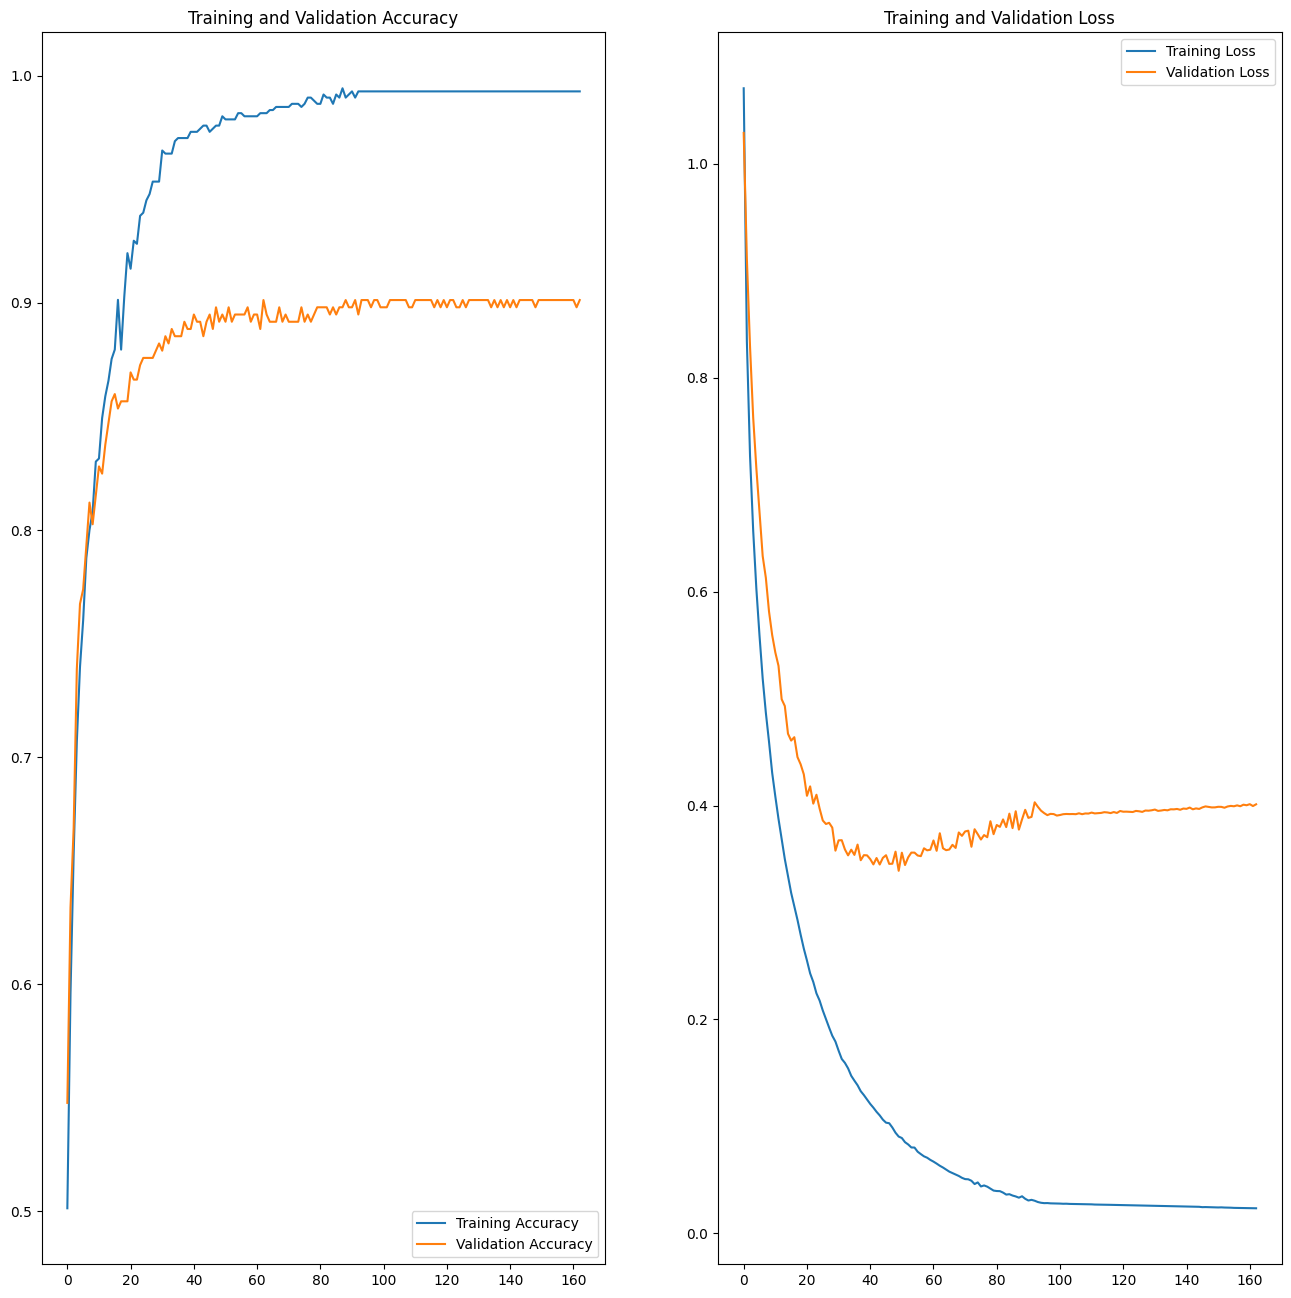

In [9]:
n_epochs = len(history.history['loss'])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(n_epochs) #change it based on epoch needed to finish building the model

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


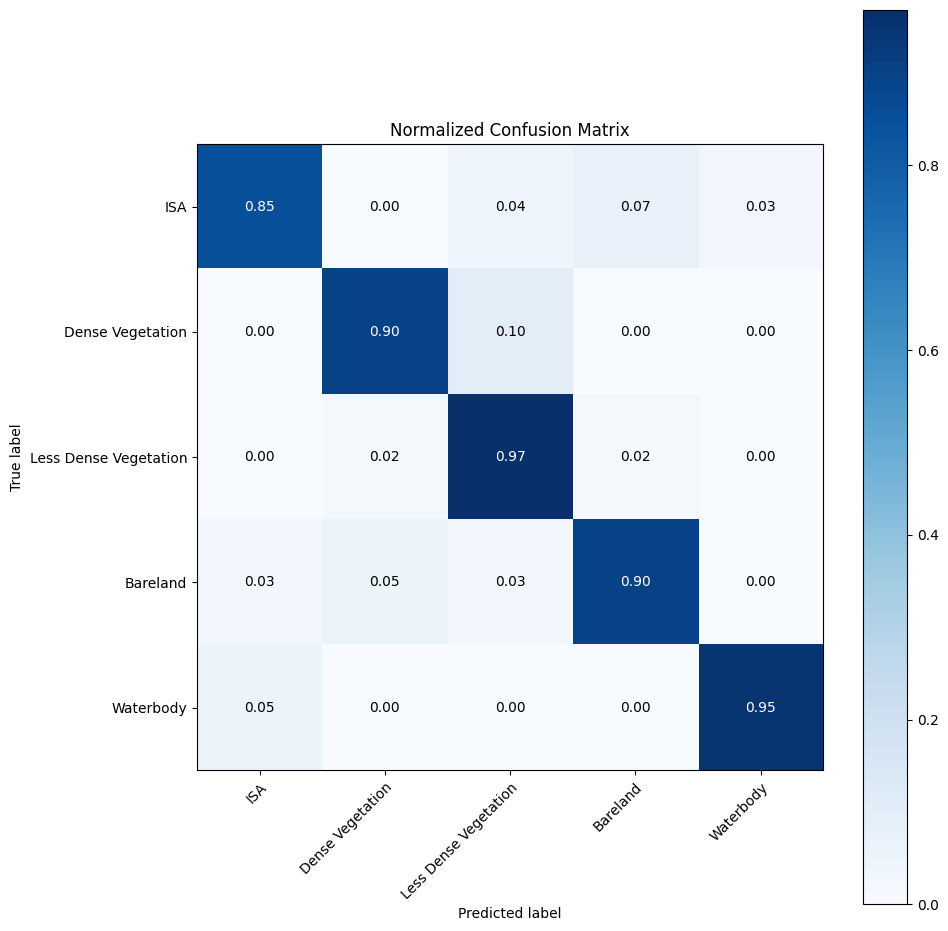

In [10]:
#confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

classes = ['ISA','Dense Vegetation','Less Dense Vegetation', 'Bareland', 'Waterbody']

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

dl_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(dl_cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(dl_cm.shape[1]),
        yticks=np.arange(dl_cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,
        title='Normalized Confusion Matrix',
        ylabel='True label',
        xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor")

fmt = '.2f'
thresh = dl_cm.max() / 2.
for i in range(dl_cm.shape[0]):
    for j in range(dl_cm.shape[1]):
        ax.text(j, i, format(dl_cm[i, j], fmt),
                ha="center", va="center",
                color="white" if dl_cm[i, j] > thresh else "black")
fig.tight_layout()

In [11]:
def permutation_importance_predict(model, X_test, y_test, feature_names, n_repeats=5):
    X_test = np.array(X_test, dtype=np.float32)
    
    # Debug: Check shapes
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    
    # Get baseline predictions
    baseline_pred = model.predict(X_test, verbose=0)
    print(f"baseline_pred shape: {baseline_pred.shape}")
    
    # Handle different y_test formats
    if len(y_test.shape) == 1:
        # If y_test is 1D (class indices), use it directly
        y_true_classes = y_test
    else:
        # If y_test is one-hot encoded, convert to class indices
        y_true_classes = np.argmax(y_test, axis=1)
    
    # Convert predictions to class indices
    baseline_pred_classes = np.argmax(baseline_pred, axis=1)
    
    baseline_acc = np.mean(baseline_pred_classes == y_true_classes)
    print(f"Baseline accuracy: {baseline_acc:.4f}")
    
    importance_scores = {}
    
    for i, feature_name in enumerate(feature_names):
        print(f"Computing importance for {feature_name}...")
        
        scores = []
        for repeat in range(n_repeats):
            X_test_perm = np.copy(X_test).astype(np.float32)
            
            # Permute feature i across all time steps
            for t in range(X_test.shape[1]):
                np.random.shuffle(X_test_perm[:, t, i])
            
            # Use predict instead of evaluate
            perm_pred = model.predict(X_test_perm, verbose=0)
            perm_pred_classes = np.argmax(perm_pred, axis=1)
            perm_acc = np.mean(perm_pred_classes == y_true_classes)
            importance_drop = baseline_acc - perm_acc
            scores.append(importance_drop)
        
        importance_scores[feature_name] = {
            'mean': np.mean(scores),
            'std': np.std(scores),
            'scores': scores
        }
        
        print(f"{feature_name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    
    return importance_scores

In [12]:
def plot_feature_importance(importance_scores):
    import matplotlib.pyplot as plt
    
    features = list(importance_scores.keys())
    means = [importance_scores[f]['mean'] for f in features]
    stds = [importance_scores[f]['std'] for f in features]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(features, means, yerr=stds, capsize=5, alpha=0.7)
    plt.ylabel('Importance Score (Accuracy Drop)')
    plt.title('Feature Importance (Permutation-based)')
    plt.xticks(rotation=0)
    
    # Add value labels on bars
    for bar, mean in zip(bars, means):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
                f'{mean:.3f}', ha='center', va='bottom')

    plt.margins(x=0.01)
    plt.tight_layout()
    plt.show()

X_test shape: (314, 24, 6)
y_test shape: (314,)
baseline_pred shape: (314, 5)
Baseline accuracy: 0.9013
Computing importance for NDVI...
NDVI: 0.1153 ± 0.0102
Computing importance for MNDWI...
MNDWI: 0.1669 ± 0.0223
Computing importance for NDBI...
NDBI: 0.1293 ± 0.0087
Computing importance for NDBSI...
NDBSI: 0.1809 ± 0.0184
Computing importance for CBI...
CBI: 0.1917 ± 0.0131
Computing importance for UCI...
UCI: 0.1726 ± 0.0158


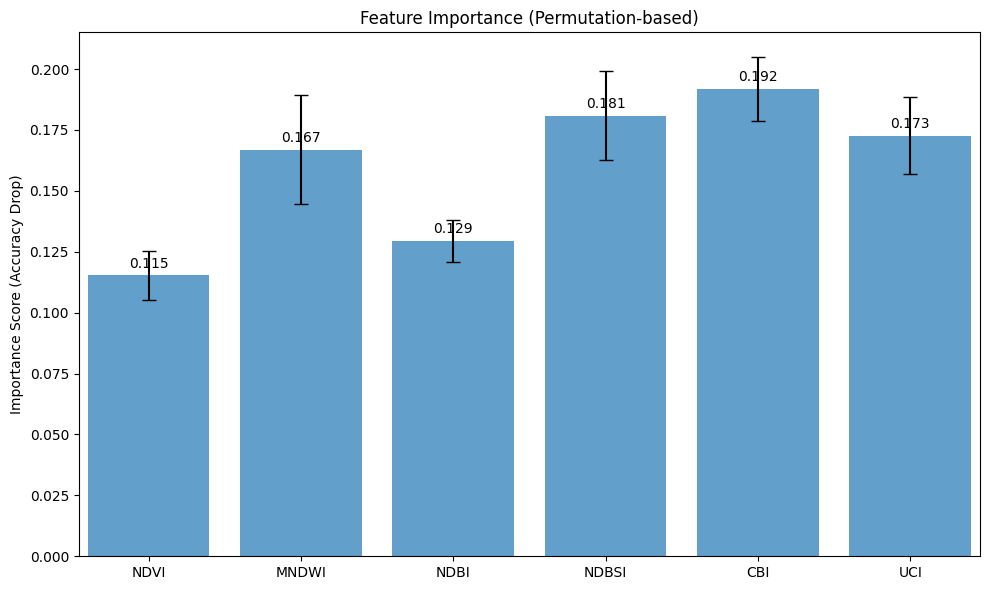


Feature Importance Ranking:
1. CBI: 0.1917 ± 0.0131
2. NDBSI: 0.1809 ± 0.0184
3. UCI: 0.1726 ± 0.0158
4. MNDWI: 0.1669 ± 0.0223
5. NDBI: 0.1293 ± 0.0087
6. NDVI: 0.1153 ± 0.0102


In [13]:
feature_names = ['NDVI', 'MNDWI', 'NDBI', 'NDBSI', 'CBI', 'UCI']
importance_results = permutation_importance_predict(model, X_test, y_test, feature_names, n_repeats=5)

plot_feature_importance(importance_results)
sorted_features = sorted(importance_results.items(), key=lambda x: x[1]['mean'], reverse=True)
print("\nFeature Importance Ranking:")
for i, (feature, scores) in enumerate(sorted_features, 1):
    print(f"{i}. {feature}: {scores['mean']:.4f} ± {scores['std']:.4f}")